## Just test if we can do stokes flow on a 3d cube

### 0. Import packages

In [2]:
import firedrake
import numpy as np
import pickle as pkl
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl
import tqdm
import emcee
import corner
import itertools
import xarray
import dtscalibration
import glob

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.AH_temp_funcs import *

%matplotlib widget

### 1. Create the starting functions and meshes

### 1a. Make a unit cube mesh

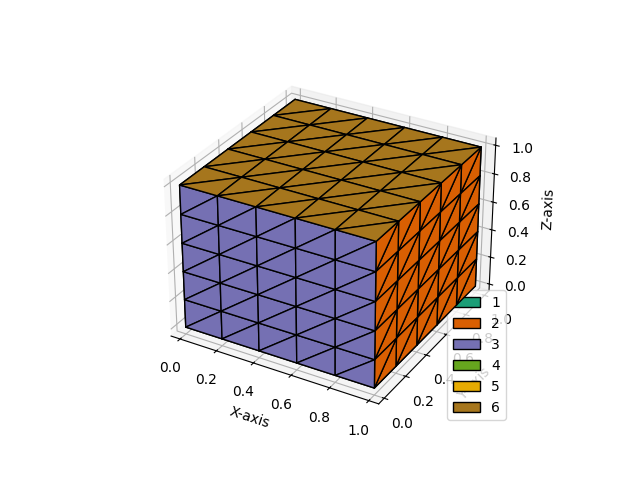

In [183]:
nx, ny, nz = 5, 5, 5

mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure().add_subplot(projection='3d')

firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.legend()
plt.show()

### 1b. Make a rectangular prism mesh

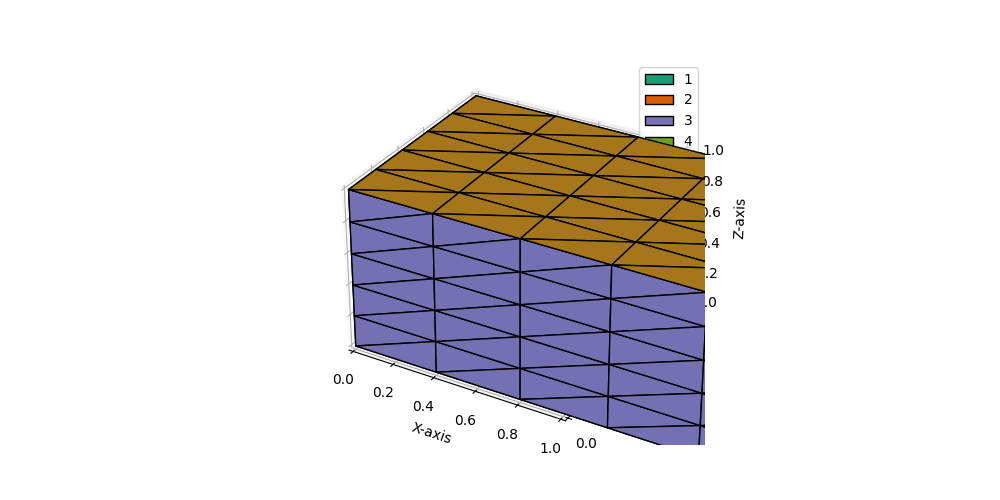

In [182]:
nx, ny, nz = 5, 5, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(2.0) # How long we want the x to be
expr = firedrake.as_vector([Lx * x, y,z])

Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.autoscale()
plt.legend()
plt.show()

### 1c. Make a rectangular prism with a sloped surface

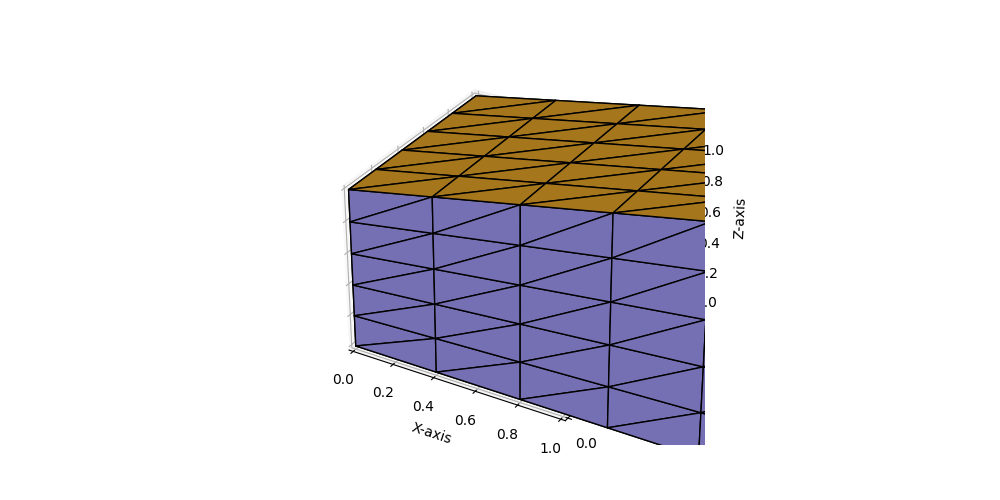

In [134]:
nx, ny, nz = 5, 5, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(2.0) # How long we want the x to be
Lz = Constant(1.0) + (x / Lx) * 1
expr = firedrake.as_vector([Lx * x, y,z * Lz])

Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

x, y, z = firedrake.SpatialCoordinate(mesh)

element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.autoscale()
plt.legend()
plt.show()

### 1d. Make a sloped bed with same angle slope (box on a slope)

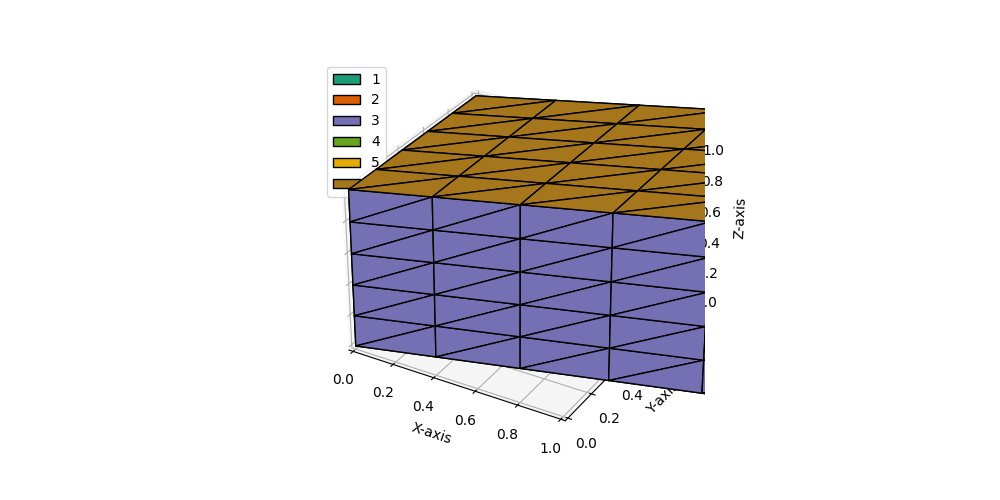

In [194]:
nx, ny, nz = 5, 5, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(2.0) # How long we want the x to be
Lz = Constant(1.0) # How much extra height on the z-axis
expr = firedrake.as_vector([Lx * x, y,z + Lz * (x / Lx)])

Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.autoscale()
plt.legend()
plt.show()

### 1e. Now set up a thickness gradient on a slope (slope bed and slope surface)

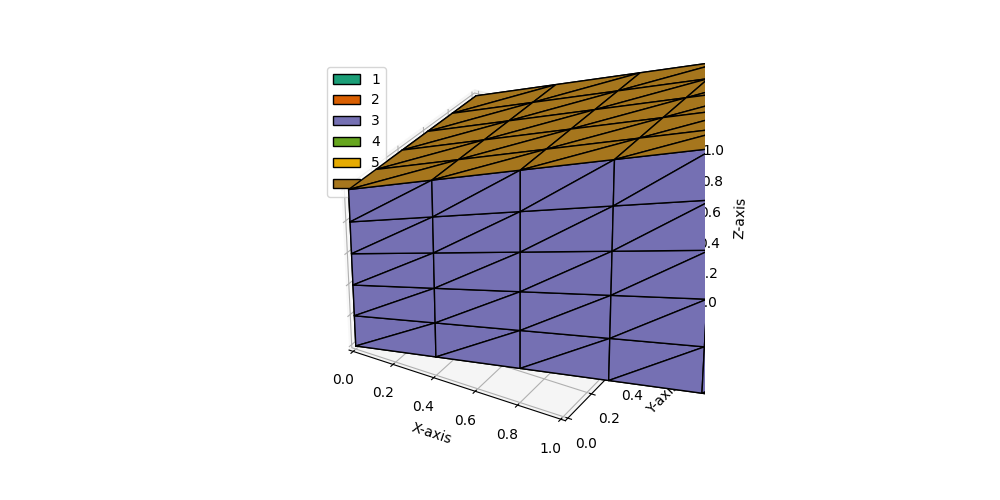

In [235]:
nx, ny, nz = 5, 5, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(2.0) # How long we want the x to be
Lz = Constant(1.0) # Initial thickness

bed_start = Constant(0.0) # Where the bed starts
bed_slope = Constant(0.5) # Where the bed ends


surf_slope = Constant(1.0)


expr = firedrake.as_vector([Lx * x, 
                            y, 
                            (1 - x / Lx) * (bed_slope * x + z * Lz) + (x / Lx) * ((bed_slope * x) + z * (Lz + (surf_slope - bed_slope) * Lx))])


Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.autoscale()
plt.legend()
plt.show()

### 2. Set up the function spaces

In [236]:
μ = Constant(5e15) #Ice


pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 3)
Y = velocity_space * pressure_space
y = firedrake.Function(Y)
u, p = firedrake.split(y)
v, q = firedrake.TestFunctions(y.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, 0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx



### 3. boundary conditions on the faces

In [237]:
face_ids = list(range(1, 7))

bc_stokes = []
for id in face_ids:
    if id == 6: pass # Skip the top face (id 5) for now
    else:
        bc = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0, 0)), id) # No flow on the boundary
        bc_stokes.append(bc)

### 4. Solve the stokes problem

In [238]:


basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}

stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

### 5. Plot the results

In [239]:
x_coords = mesh.coordinates.dat.data[:,0]
y_coords = mesh.coordinates.dat.data[:,1]
z_coords = mesh.coordinates.dat.data[:,2]

u_solve = np.zeros(len(x_coords))
v_solve = np.zeros(len(y_coords))
w_solve = np.zeros(len(z_coords))

for n, i in enumerate(y.at(mesh.coordinates.dat.data[:])):
    u_solve[n] = i[0][0]
    v_solve[n] = i[0][1]
    w_solve[n] = i[0][2]

Text(0.5, 0, 'Z-axis')

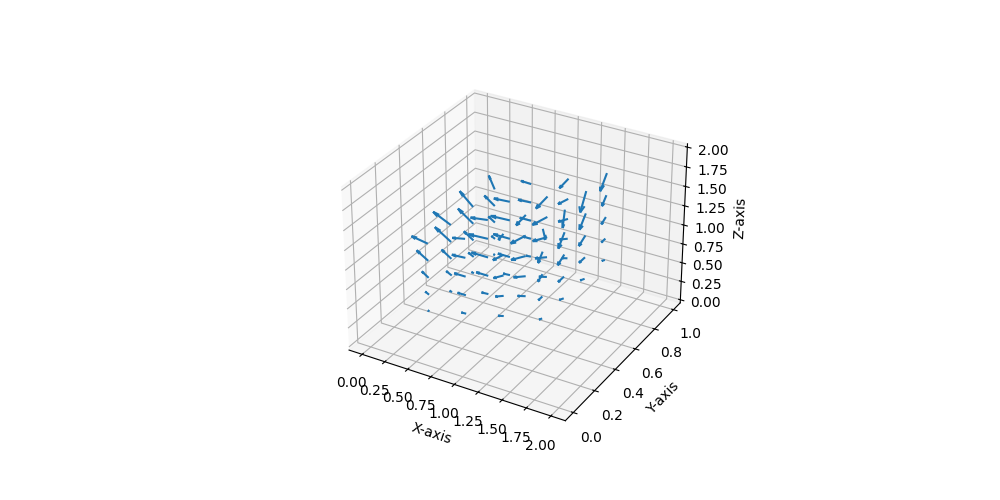

In [240]:
ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')
ax.autoscale()
ax.quiver(x_coords, y_coords, z_coords, u_solve, v_solve, w_solve, length=5e12) # Adjus, normalize=False, arrow_length_ratio=0.4,)

# Set the axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

### 5. Save the results

In [26]:
output_file = firedrake.output.VTKFile("flowfield_cube.pvd")
output_file.write(y.sub(0))